# Learning Symmetric Rules with SATNet
SymSATNet is a variant of SATNet, which abbreviates symmetry-aware SATNet.
SymSATNet assumes that some symmetries of the target rules are given a priori although the rules themselves are unknown.
We incorporated the symmetries into the SATNet's objective, and derive the equivariance requirement of the paramteter matrix of SATNet.
Consequently, SymSATNet can learn with significantly reduced number of parameters using the basis elements of the space of equivariant matrices. 

For the users who cannot specify the symmetries in advance, we also presented an automatic symmetry-detection algorithm, denoted by SymFind.
The input of SymFind is the parameter matrix of SATNet learnt by a fixed number of training steps.
SymFind then returns $G_0$, the strongest level of symmetries among the groups defined by our grammar which closely approximate the symmetries of the input matrix.
After a further validation step to refine $G_0$, it can be used to run SymSATNet-Auto, where we train SymSATNet with a parameter initialised by $G_0$-equivariant matrix. 

In this notebook, we report the experimental results using Sudoku, the completion problem of Rubik's cube.
We compared our SymSATNet and SymSATNet-Auto with two baselines, SATNet-Plain (original SATNet with no auxiliary variables) and SATNet-300aux (original SATNet with 300 auxiliary variables).
As results, we showed the potential and the robustness of SymSATNet and SymSATNet-Auto to learn faster and generalise better than SATNet-Plain, and SATNet-300aux.
We also see the ability of SymFind to recover the group symmetries from noisy equivariant matrices under arbitrary four groups.

In [1]:
# Setup
from main import main
from utils.grammar import *
from utils.group import *
from utils.symfind import *
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

models = ["SATNet-Plain", "SATNet-300aux", "SymSATNet", "SymSATNet-Auto"]
save_dir = ".results/"

args = dict()
args["trial_num"] = 1
args["gpu_num"] = 0
args["save"] = True

In [2]:
# Plot functions
def fill_ax(ax, data, xlabel, ylabel):
    for model in range(len(models)):
        points = data[model]
        ax.plot(points, label = models[model])
        ax.set_xlabel(xlabel, size = 13, color = 'black')
        ax.set_ylabel(ylabel, size = 13, color = 'black')
        ax.legend(ncol = 2, fontsize = 12, framealpha = 0.5)
        
def plot(results_dir):
    errors, times = [], []
    for model in models:
        with open(results_dir + model + "/logs/test.csv", "r") as f:
            head = next(f)
            error, time = [], []
            for line in f:
                data = line.strip().split(",")
                error.append(float(data[2]))
                time.append(float(data[3]))
            errors.append(error)
            times.append(time)

    errors = np.array(errors)
    times = np.array(times)

    plt.rc("xtick", labelsize = 13, color = 'black')
    plt.rc("ytick", labelsize = 13, color = 'black')
    fig, axes = plt.subplots(nrows = 2, ncols = 1)
    fig.tight_layout(pad = 1)
    fill_ax(axes[0], 1 - errors, "Epochs", "Test Accuracy")
    fill_ax(axes[1], times, "Epochs", "Time (sec)")
    fig.set_figheight(7)
    plt.show()

## Sudoku
Our first task is Sudoku.
The logical formula of the Sudoku's constraints possesses symmetries represented by a permutation group.
This permutation group acts on the logical formula by swapping the occurences of truth variables.
In Sudoku, the validity of a solution is preserved by any permutation action defined by an element of $G = (S_3 \wr S_3) \otimes (S_3 \wr S_3) \otimes S_9$.
SymSATNet reduces the number of parameters by using the basis elements of the equivariant matrices under $G$.

We compared the performance of SATNet-Plain, SATNet-300aux, SymSATNet using a $9 \times 9$ Sudoku dataset which consist of 9K training instances and 1K test instances.
The results are shown as follows.

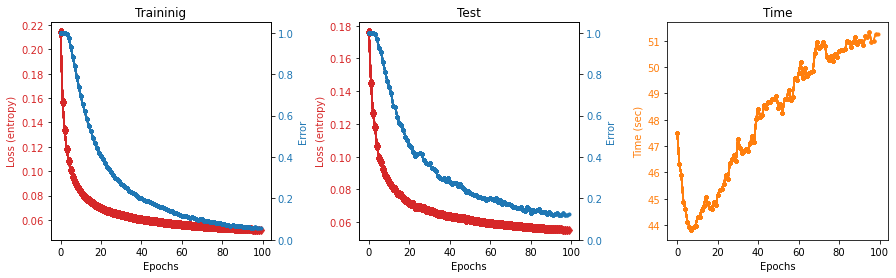

In [2]:
# SATNet-Plain with Sudoku
args["problem"] = "sudoku"
args["model"] = "SATNet-Plain"
args["corrupt_num"] = 0
main(**args)

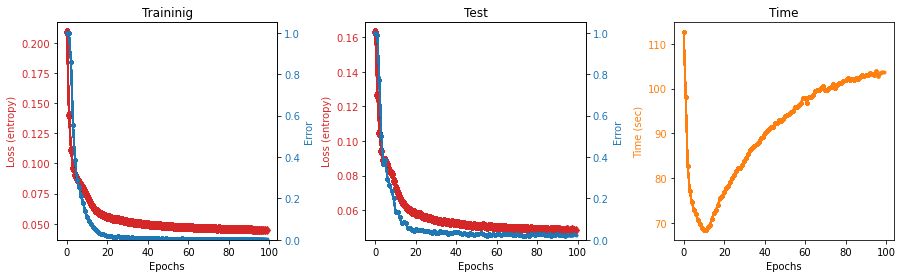

In [3]:
# SATNet-300aux with Sudoku
args["problem"] = "sudoku"
args["model"] = "SATNet-300aux"
args["corrupt_num"] = 0
main(**args)

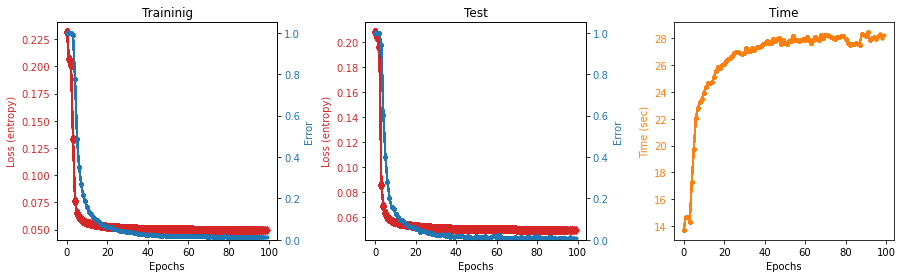

In [4]:
# SymSATNet with Sudoku
args["problem"] = "sudoku"
args["model"] = "SymSATNet"
args["corrupt_num"] = 0
main(**args)

In SymSATNet-Auto, we applied the parameter matrix of SATNet-Plain in 10th epoch to SymFind to get the symmetries represented by a group $G_0$ which approximates $G = (S_3 \wr S_3) \otimes (S_3 \wr S_3) \otimes S_9$ well.
After getting $G_0$, we ran a validation step to refine $G_0$ by measuring the usefulness of each smaller parts of $G_0$.
For example, if we got $G_0 = (S_3 \wr S_3) \otimes (S_3 \wr S_3) \otimes S_9$,
we first checked whether $G_1' = (S_3 \wr I_3) \otimes (I_3 \wr I_3) \otimes I_9$ is useful;
tested the improvement of validation accuracy obtained by projecting the SATNet-Plain's parameter into the $G_1'$-equivariant space.
We repeated this process with $G_2' = (I_3 \wr S_3) \otimes (I_3 \wr I_3) \otimes I_9$, $G_3' = (I_3 \wr I_3) \otimes (S_3 \wr I_3) \otimes I_9$, $\ldots$,
and if $G_1'$ and $G_3'$ were only found out to be useful, we combine them to get the result $G' = (S_3 \wr I_3) \otimes (S_3 \wr I_3) \otimes I_9$.
After the validation step, we continue to train SymSATNet with parameter initialised by projecting the SATNet-Plain's parameter into the $G'$-equivariant space.

For SymSATNet-Auto, we used 8K training examples and 1K validation examples, and 1K test examples.
The results are shown in the following.

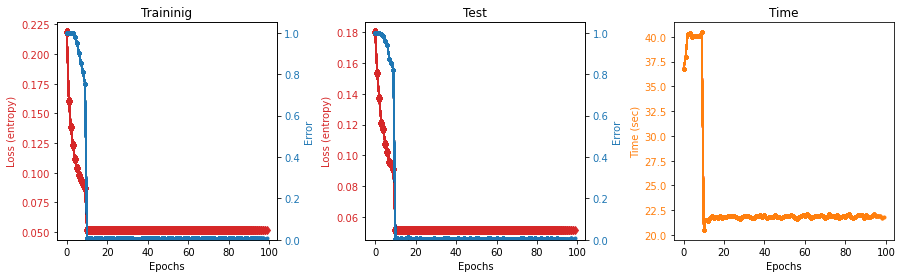

In [3]:
# SymSATNet-Auto with Sudoku
args["problem"] = "sudoku"
args["model"] = "SymSATNet-Auto"
args["corrupt_num"] = 0
main(**args)

The following are the total results in the task of Sudoku.

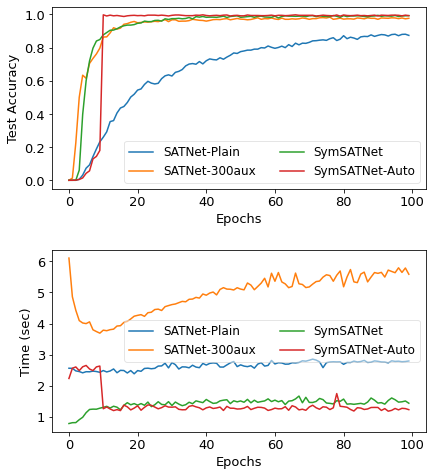

In [44]:
# Total results in Sudoku
results_dir = save_dir + f"sudoku_trial_{args['trial_num']}_corrupt_0/"
plot(results_dir)

## Completion Problem of Rubik's Cube
Our second task is what we called the completion problem of Rubik's cube.
In the problem, we are given a Rubik's cube composed of $6 \times 6 \times 6$ cells called facelets, some of which are initially colorless.
Then, we are asked to fill some colors in the blank facelets such that the completed color assignment of the Rubik's cube is solvable.
This problem also possesses certain symmetries, represented by a permutation group $G = \mathcal{R}_{54} \otimes \mathcal{R}_6$.
Here $\mathcal{R}_{54}$ is the Rubik's cube group corresponding to the moves on the Rubik's cube, and $\mathcal{R}_6$ is the permutation group corresponding to the rotations of the whole Rubik's cube.
Intuitively, we can easily see that a solvable color assignment of a Rubik's cube is still solvable after a permutation action represented by an element in $G$.

We compared the performance of SATNet-Plain, SATNet-300aux, SymSATNet using a $6 \times 6 \times 6$ Rubik's cube dataset which consist of 9K training instances and 1K test instances.
The results are shown as follows.

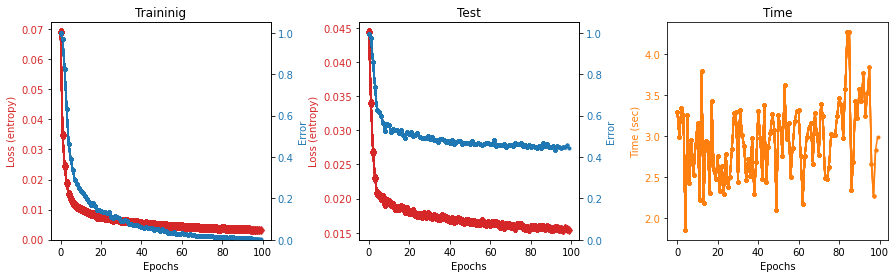

In [8]:
# SATNet-Plain with cube
args["problem"] = "cube"
args["model"] = "SATNet-Plain"
args["corrupt_num"] = 0
main(**args)

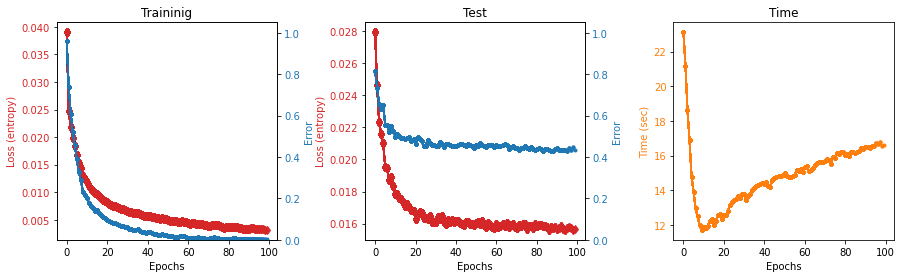

In [4]:
# SATNet-300aux with cube
args["problem"] = "cube"
args["model"] = "SATNet-300aux"
args["corrupt_num"] = 0
main(**args)

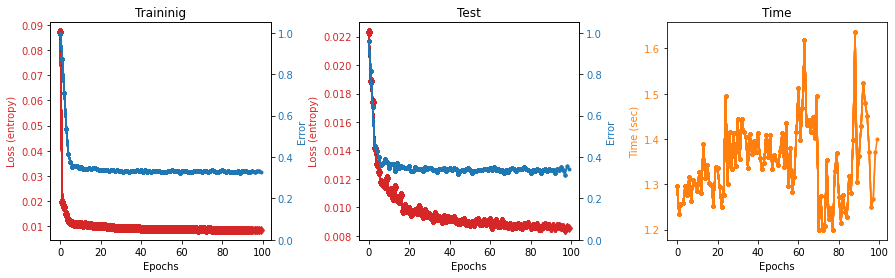

In [5]:
# SymSATNet with cube
args["problem"] = "cube"
args["model"] = "SymSATNet"
args["corrupt_num"] = 0
main(**args)

In Rubik's cube with SymSATNet-Auto, we apply the parameter matrix of SATNet-Plain in 20th epoch to SymFind to get the symmetries represented by a group $G_0$ which approximates $G = \mathcal{R}_{54} \otimes \mathcal{R}_6$ well.
After getting $G_0$, we again ran a validation step to refine $G_0$.

For SymSATNet-Auto, we used 8K training examples and 1K validation examples, and 1K test examples, as before.

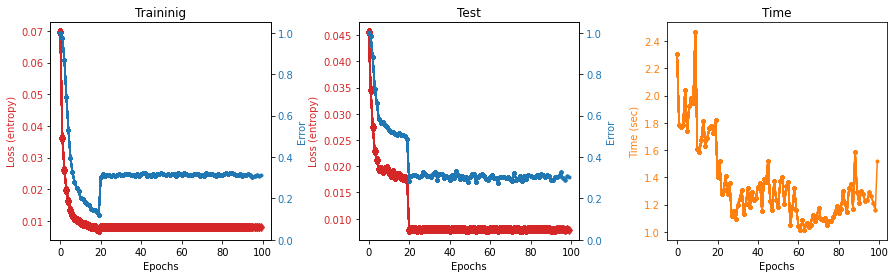

In [2]:
# SymSATNet-Auto with cube
args["problem"] = "cube"
args["model"] = "SymSATNet-Auto"
args["corrupt_num"] = 0
main(**args)

The following are the total results in the task of Rubik's cube.

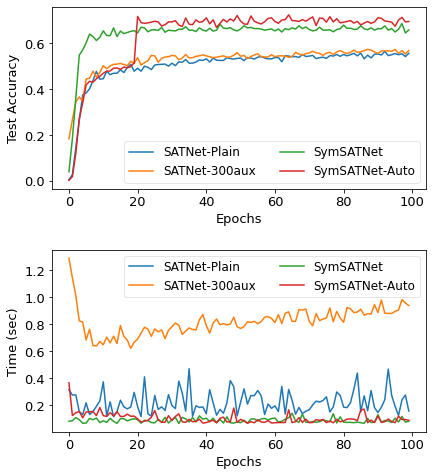

In [45]:
# Total results in cube
results_dir = save_dir + f"cube_trial_{args['trial_num']}_corrupt_0/"
plot(results_dir)

## Noisy Sudoku
We tested the robustness of SymSATNet and SymSATNet-Auto compared to SATNet and SATNet-300aux, using a noisy Sudoku dataset.
In the paper, we presented the results when the number of corruption is 0~3.
Here, we fixed the number of corrupted cells by 2.

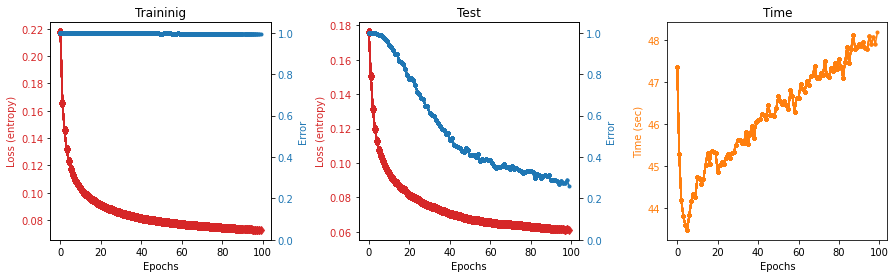

In [6]:
# SATNet-Plain in noisy Sudoku
args["problem"] = "sudoku"
args["model"] = "SATNet-Plain"
args["corrupt_num"] = 2
main(**args)

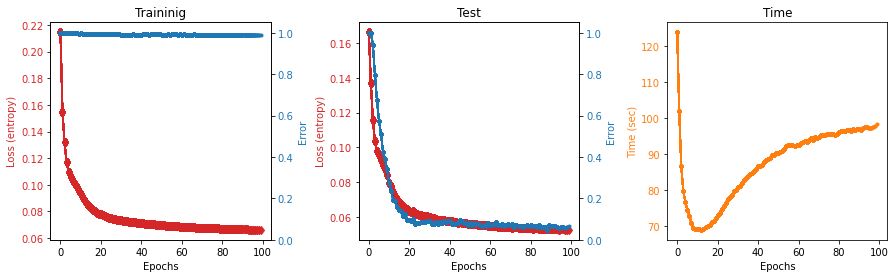

In [7]:
# SATNet-300aux in noisy Sudoku
args["problem"] = "sudoku"
args["model"] = "SATNet-300aux"
args["corrupt_num"] = 2
main(**args)

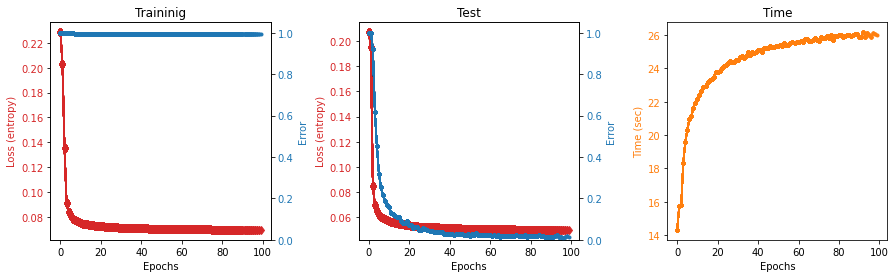

In [8]:
# SymSATNet in noisy Sudoku
args["problem"] = "sudoku"
args["model"] = "SymSATNet"
args["corrupt_num"] = 2
main(**args)

In [ ]:
# SymSATNet-Auto in noisy Sudoku
args["problem"] = "sudoku"
args["model"] = "SymSATNet-Auto"
args["corrupt_num"] = 2
main(**args)

The following are the total results in the task of noisy Sudoku.

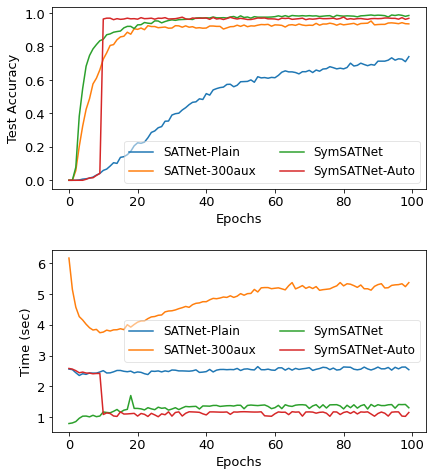

In [46]:
# Total results in noisy Sudoku
results_dir = save_dir + f"sudoku_trial_{args['trial_num']}_corrupt_2/"
plot(results_dir)

## Noisy Rubik's Cube
We tested the robustness of SymSATNet and SymSATNet-Auto compared to SATNet and SATNet-300aux, using a noisy Rubik's cube dataset.
Again, here we fixed the number of corrupted facelets by 2.

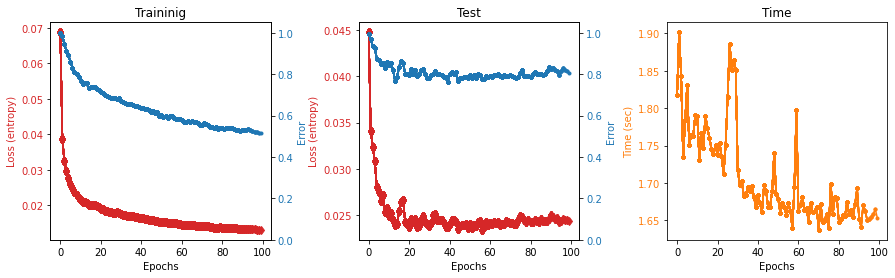

In [9]:
# SATNet-Plain in noisy cube
args["problem"] = "cube"
args["model"] = "SATNet-Plain"
args["corrupt_num"] = 2
main(**args)

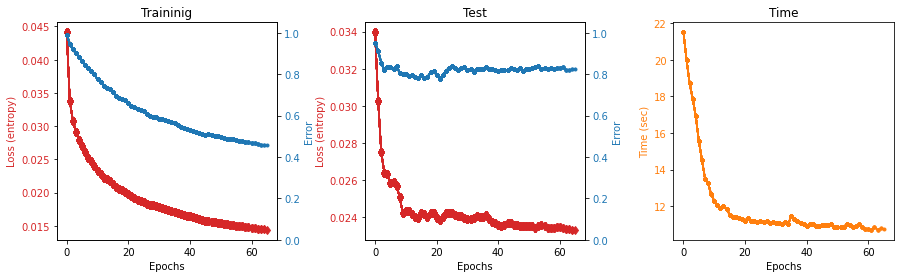

  0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
# SATNet-300aux in noisy cube
args["problem"] = "cube"
args["model"] = "SATNet-300aux"
args["corrupt_num"] = 2
main(**args)

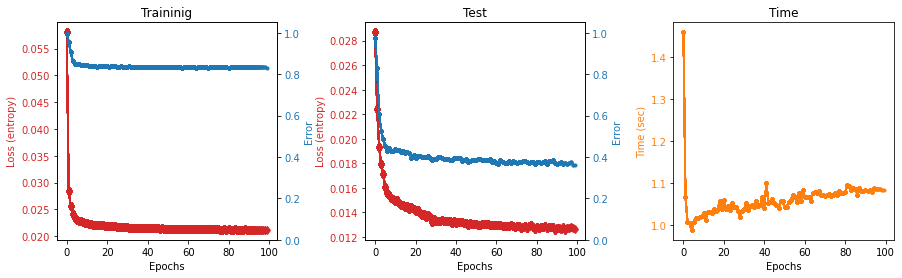

In [4]:
# SymSATNet in noisy cube
args["problem"] = "cube"
args["model"] = "SymSATNet"
args["corrupt_num"] = 2
main(**args)

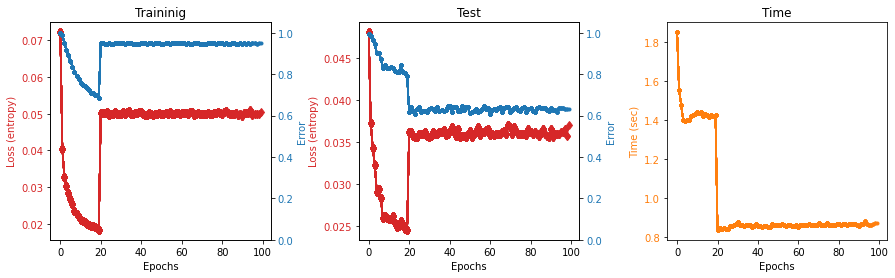

In [2]:
# SymSATNet-Auto in noisy cube
args["problem"] = "cube"
args["model"] = "SymSATNet-Auto"
args["corrupt_num"] = 2
main(**args)

The following are the total results in the task of noisy Rubik's cube.

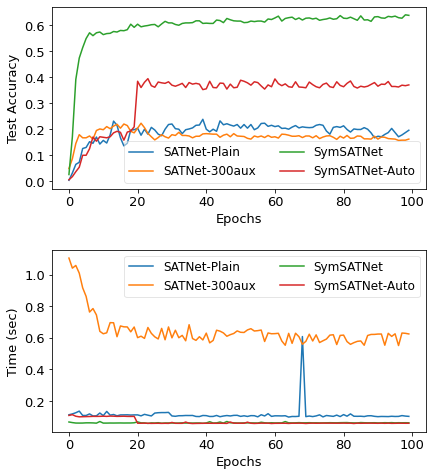

In [47]:
# Total results in noisy cube
results_dir = save_dir + f"cube_trial_{args['trial_num']}_corrupt_2/"
plot(results_dir)

## Robustness of SymFind
To test the robustness of SymFind algorithm, we picked arbitrary four permutation groups $G_i$'s defined by our grammar, and applied noise-corrupted $G_i$-equivariant matrices to SymFind to recover the symmetries.
We computed the accuracies of these recovering in two ways: whether it exactly returned the full group structure (full accuracy), or whether it returned a subgroup structure (partial accuracy).

We used the following four groups:
\begin{align*}
G_1 &= \mathbb{Z}_3 \oplus \mathbb{Z}_3 \oplus \mathbb{Z}_3 \oplus \mathbb{Z}_3 \oplus \mathbb{Z}_3, \\
G_2 &= S_3 \wr S_{10}, \\
G_3 &= (S_3 \wr S_3) \oplus \mathbb{Z}_3, \\
G_4 &= S_2 \otimes S_2 \otimes S_2,
\end{align*}

and repeated 1K trials of recovering to compute the full accuracy and the partial accuracy.
The results are shown as follows.

In [5]:
# Robustness of SymFind
grammars = [Sum(Cyclic(3), Sum(Cyclic(3), Sum(Cyclic(3), Sum(Cyclic(3), Cyclic(3))))),
            Wreath(Symm(3), Symm(10)),
            Sum(Wreath(Symm(3), Symm(3)), Cyclic(3)),
            Kron(Kron(Symm(2), Symm(2)), Symm(2))]
rtols = [0.05, 0.05, 0.1, 0.025]
max_errs = [0.5, 0.5, 0.5, 0.5]
shuffle = [True, True, True, False]
n_trials = 1000
full_accs = torch.zeros(4)
partial_accs = torch.zeros(4)

for i in range(4):
    grammar = grammars[i]
    for _ in tqdm(range(n_trials)):
        perm = torch.randperm(grammar.dim) if shuffle[i] else torch.arange(grammar.dim)
        G = Group(grammar, perm)

        M = torch.randn(G.grammar.dim, G.grammar.dim)
        M_proj = G.proj(M)

        noise = torch.rand(M.shape)
        noise_ratio = 5e-3
        M_noise = M_proj + noise * noise_ratio

        grammar_0, perm_0 = symfind(M_noise, rtols[i], max_errs[i])
        G_0 = Group(grammar_0, perm_0)

        if torch.allclose(M_proj, G_0.proj(M)):
            full_accs[i] += 1

        if torch.allclose(M_proj, G_0.proj(M_proj)) and not torch.allclose(M, G_0.proj(M)):
            partial_accs[i] += 1
            
print("Full accuracy:", full_accs / n_trials)
print("Partial accuracy:", partial_accs / n_trials)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Full accuracy: tensor([0.7690, 0.6110, 0.7900, 0.9440])
Partial accuracy: tensor([0.7970, 0.7940, 0.8640, 0.9530])
